In [37]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression

from p4_generate_dataset import SAMPLE_ELOS

In [38]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.head()

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
0,2kr1bnr/ppp1pppp/2n5/3q4/6b1/5N2/PPPPBPPP/RNBQ...,b1c3,1837.177419,0.451613,62,h2h3,0.643006,0.848325,0.997261,0.829531,...,b1c3,True,False,b1c3,True,b1c3,True,0.848325,b1c3,True
1,2kr1bnr/pppbpppp/2n1q3/8/8/2N2N2/PPPPBPPP/R1BQ...,f1e1,1400.066667,0.550000,60,d2d4,0.421480,0.703704,0.986595,0.703926,...,f1e1,True,False,f1e1,True,f1e1,True,0.703704,f1e1,True
2,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,d2d4,1296.660714,0.625000,112,d2d4,0.000000,0.860670,0.988769,0.616480,...,d2d4,True,True,e1g1,False,d2d4,True,0.860670,d2d4,True
3,r1b1kb1r/ppp1pppp/2n1qn2/8/8/2N2N2/PPPPBPPP/R1...,e1g1,1317.025455,0.603636,275,d2d4,0.000000,0.791887,0.989855,0.593914,...,d2d4,True,True,e1g1,False,d2d4,True,0.791887,d2d4,True
4,r1b1kb1r/ppp1pppp/2n2n2/3q4/8/5N2/PPPPBPPP/RNB...,e1g1,1626.631579,0.438596,57,d2d4,0.299516,0.883598,0.978844,0.720653,...,e1g1,True,False,e1g1,True,e1g1,True,0.883598,e1g1,True


In [39]:
df.describe()

,avg_elo,global_winrate,count,fragility_score,delta,variance,score_base,winrate_500,score_500,mix_score_500,...,mix_score_850,winrate_1200,score_1200,mix_score_1200,winrate_1500,score_1500,mix_score_1500,winrate_2200,score_2200,mix_score_2200
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,1532.871038,0.476793,531.174897,0.811931,0.820966,0.980708,0.871202,0.132313,0.871202,0.816448,...,0.816448,0.471575,0.871202,0.817352,0.480479,0.871202,0.818707,0.402570,0.871202,0.820966
std,188.159047,0.081600,2980.339144,0.171884,0.108598,0.065920,0.074793,0.301689,0.074793,0.100063,...,0.100063,0.153756,0.074793,0.093080,0.105495,0.074793,0.090769,0.312500,0.074793,0.108598
min,1128.297297,0.040000,50.000000,0.000000,0.000000,0.000000,0.411915,0.000000,0.411915,0.395944,...,0.395944,0.000000,0.411915,0.341830,0.000000,0.411915,0.213644,0.000000,0.411915,0.000000
25%,1377.616828,0.430551,65.000000,0.716848,0.791887,0.989448,0.839757,0.000000,0.839757,0.773045,...,0.773045,0.388889,0.839757,0.781200,0.421053,0.839757,0.787318,0.000000,0.839757,0.791887
50%,1530.909284,0.479279,105.000000,0.857526,0.851852,0.997409,0.890309,0.000000,0.890309,0.841417,...,0.841417,0.473684,0.890309,0.838124,0.480000,0.890309,0.838657,0.428571,0.890309,0.851852
75%,1692.551379,0.519960,208.250000,0.945841,0.881834,0.999047,0.923604,0.000000,0.923604,0.889485,...,0.889485,0.545982,0.923604,0.880761,0.533381,0.923604,0.874744,0.569876,0.923604,0.881834
max,1963.800000,0.941176,35816.000000,1.000000,1.000000,1.000000,0.975352,1.000000,0.975352,0.963782,...,0.963782,1.000000,0.975352,0.964730,1.000000,0.975352,0.977956,1.000000,0.975352,1.000000


In [40]:
results = []
grouped = df.groupby("fen").first().reset_index()

for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_frag_col = f"is_frag_best_{elo}"
    is_delta_col = f"is_delta_best_{elo}"
    is_mix_col = f"is_mix_best_{elo}"

    avg_is_best = grouped[is_best_col].mean()
    avg_is_engine_best = grouped[is_engine_col].mean()
    avg_is_frag_best = grouped[is_frag_col].mean()
    avg_is_delta_best = grouped[is_delta_col].mean()
    avg_is_mix_best = grouped[is_mix_col].mean()

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_frag_best": avg_is_frag_best,
        "avg_is_delta_best": avg_is_delta_best,
        "avg_is_mix_best": avg_is_mix_best,
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_frag_best,avg_is_delta_best,avg_is_mix_best
0,500,0.759036,0.401606,0.931727,0.755020,0.755020
1,850,0.771084,0.425703,0.763052,0.771084,0.771084
2,1200,0.771084,0.393574,0.751004,0.755020,0.755020
3,1500,0.779116,0.405622,0.730924,0.783133,0.783133
4,2200,0.763052,0.381526,0.779116,0.763052,0.763052


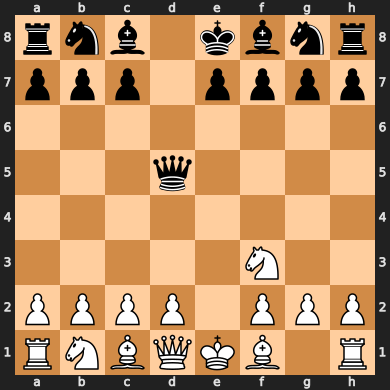

In [41]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [42]:
filtered

,fen,next_move,avg_elo,global_winrate,count,engine_move,fragility_score,delta,variance,score_base,...,recommended_move_2200,is_best_2200,is_engine_best_2200,frag_rec_2200,is_frag_best_2200,delta_rec_2200,is_delta_best_2200,mix_score_2200,mix_rec_2200,is_mix_best_2200
312,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,b8c6,1620.834452,0.487696,447,c8g4,0.904357,0.807760,0.996609,0.902909,...,c8g4,False,False,c8g4,False,c8g4,False,0.807760,c8g4,False
313,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,c7c6,1771.480000,0.472727,275,c8g4,0.904357,0.809524,0.999615,0.904499,...,c8g4,False,False,c8g4,False,c8g4,False,0.809524,c8g4,False
314,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,c8f5,1654.173469,0.418367,392,c8g4,0.904357,0.862434,0.998305,0.921698,...,c8g4,False,False,c8g4,False,c8g4,False,0.862434,c8g4,False
315,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,c8g4,1717.406507,0.476440,2674,c8g4,0.904357,0.911817,0.978859,0.931678,...,c8g4,False,False,c8g4,False,c8g4,False,0.911817,c8g4,False
316,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,d5a5,1692.772210,0.489749,439,c8g4,0.904357,0.804233,0.999209,0.902600,...,c8g4,False,False,c8g4,False,c8g4,False,0.804233,c8g4,False
317,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,d5d6,1741.690647,0.467626,139,c8g4,0.904357,0.788360,0.999589,0.897435,...,c8g4,False,False,c8g4,False,c8g4,False,0.788360,c8g4,False
318,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,d5d8,1673.037500,0.441667,1920,c8g4,0.904357,0.818342,0.999484,0.907394,...,c8g4,False,False,c8g4,False,c8g4,False,0.818342,c8g4,False
319,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,d5e4,1405.866397,0.421053,247,c8g4,0.904357,0.763668,0.977369,0.881798,...,c8g4,False,False,c8g4,False,c8g4,False,0.763668,c8g4,False
320,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,d5e6,1425.290780,0.445390,705,c8g4,0.904357,0.693122,0.798255,0.798578,...,c8g4,False,False,c8g4,False,c8g4,False,0.693122,c8g4,False
321,rnb1kbnr/ppp1pppp/8/3q4/8/5N2/PPPP1PPP/RNBQKB1...,e7e5,1394.318725,0.426295,251,c8g4,0.904357,0.719577,0.987596,0.870510,...,c8g4,False,False,c8g4,False,c8g4,False,0.719577,c8g4,False


# Regression Analysis

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 75 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    486 non-null    object 
 1   next_move              486 non-null    object 
 2   avg_elo                486 non-null    float64
 3   global_winrate         486 non-null    float64
 4   count                  486 non-null    int64  
 5   engine_move            486 non-null    object 
 6   fragility_score        486 non-null    float64
 7   delta                  486 non-null    float64
 8   variance               486 non-null    float64
 9   score_base             486 non-null    float64
 10  winrate_500            486 non-null    float64
 11  historical_best_500    486 non-null    object 
 12  score_500              486 non-null    float64
 13  recommended_move_500   486 non-null    object 
 14  is_best_500            486 non-null    bool   
 15  is_eng

In [44]:
# df["f_cross_d"] = df["fragility_score"] * df["delta"]
# df["f_cross_v"] = df["fragility_score"] * df["variance"]
# df["d_cross_v"] = df["delta"] * df["variance"]

selected_features = ["fragility_score", "delta", "variance", "score_base"] #"f_cross_d", "f_cross_v", "d_cross_v", ]
X = df[selected_features]
y = df["is_best_1500"]

In [45]:
model = LinearRegression()
model.fit(X, y)

for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.3f}")

fragility_score: -0.251
delta: 0.719
variance: -0.069
score_base: 0.133


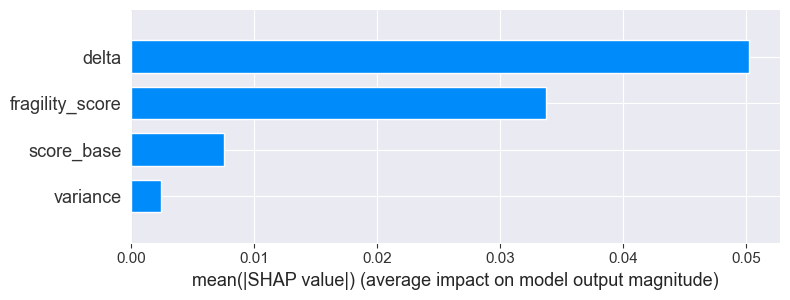

In [46]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type="bar")

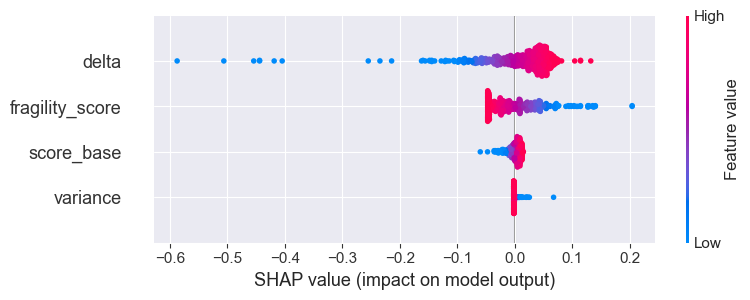

In [47]:
shap.summary_plot(shap_values, X, show=True)

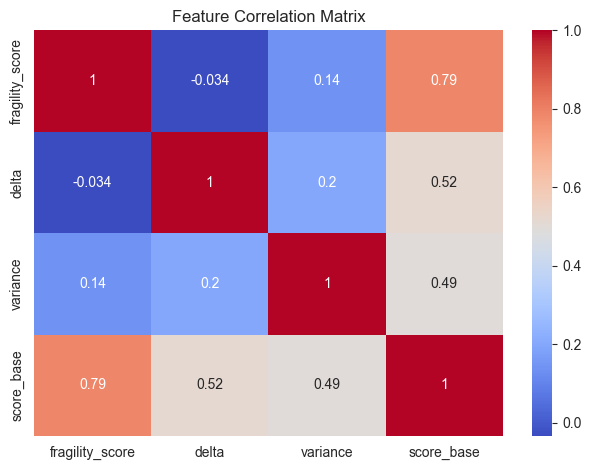

In [48]:
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()